# Introduction to dynamic programming with discrete states and discrete actions

The goal of this notebook is to build up a value function iteration step by step.
To do so, we consider a growth model without uncertainty. The task is to do all the #TODO's.

# 2. The recursive formulation
The problem above can be formualted in recursive from:
\begin{align}
&V(k) = \max_{c} u(c) + \beta V(k') \\
\end{align}

Suppose there is a single agent with $\beta = 0.9$, v(c) = log(c), there are two states which are iid with equal probabilities $\pi_1 = \pi_2 = 0.5$ and the firm’s production function is:

$$ f(k,l) = 0.9k^{0.3} +0.3k \text{,   } f(k,2) = 1.1k^{0.3} +0.9k$$

Discretize the possible capital values to 50 points. Use value function iteration to compute the policy functions (one for each shock) for consumption and investment. Plot these functions. Now use 500 for admissible capital levels and redo the exercise.


We can plug the constraint directly into the maximization problem and get
\begin{align}
&V(k) = \max_{k'} u(k^{0.3} + 0.5 k - k') + \beta V(k'). \\
\end{align}
The above equation is also called **Bellman equation**.
The goal of value function iteration is to find a function V which fullfills the Bellman equation for all possible $k$.
In this example, the **state** is $k$ and the **policy** or **action** is $k'$.

The mapping $ k \rightarrow V(k)$ is the value function.  
The mapping $ k \rightarrow p(k)=k'$ is the policy function.  
Given the value function, we can extract the policy function using
\begin{align}
p(k) = \text{arg}\max_{k'} u(k^{0.3} + 0.5 k - k') + \beta V(k')
\end{align}


# 3. Discrete states and actions
We can restrict the state and the actions to be discrete and to take values in a finite set with $N$ discrete values $\mathcal{K}:=\{k_1, k_2, \dots k_N\}$.
Since the state can only take discrete values, the value function takes discrete values as well.
We can then represent the entire value function as a vector $\begin{bmatrix}V_1\\
V_2\\
\dots \\
V_N
\end{bmatrix} = \begin{bmatrix}V(k_1)\\
V(k_2)\\
\dots \\
V(k_N)
\end{bmatrix}.$

# 4. Value function iteration
In this section we decompose value function iteration for discrete states and actions into several steps.
The code for this steps is incomplete and it might be a nice exercise to complete it.

## 4.1 Initialization
To start with value function iteration, we need to chose a grid for the states and the actions.
In this example, the action in period $t$ determines the state in period $t+1$, therefore the grid for states and actions is the same.

In [62]:
import numpy as np

# If you change any of these values, comment out the assertions

N = 500 # number of grid-points for the capital grid
k_low = 0.1 # lower bound for the capital grid
k_high = 10 # upper bound for capital grid
k_grid = np.linspace(k_low, k_high, N).reshape(1, N) #grid for capital

# Now we initialize the value function, I like to initialize it to zero.
V_init = np.zeros((2, N))

## 4.2 Value function update for a given state
The idea value function iteration is to update the value function vector accroding to
$$
V_i^{\text{updated}}=\max_{k_j \in \mathcal{K}} u(k_i^{0.3} + 0.5 k_i - k_j) + \beta V_j
$$
Our first step will be to implement this update.
For the utility function we chose CRRA utility, with coefficient of relative risk aversion $\gamma = 2$.

In [63]:
# I start out with some functions, which may be helpful
# If you change the parameters, the assertions don't make sense anymore
gamma = 2.
beta = 0.9

def u(c, gamma=gamma):
    """
    input: 
    c: consumption
    
    output:
    utility received from consumption
    """
    return np.log(c)

# hint: try to understand what this function does first, it is useful for vf_update!
def actionvalue_allchoices(k_index, V_old):
    """
    input:
    k_index: index so that k_grid[index] corresponds to value of capital this period (state)
    V_old: approximation to the value function. V_old[i] approximates V(k_grid[i]).
    
    output:
    action_value: value of all possible state-action pairs.
    """
    k = k_grid[0,k_index]
    action_value = np.zeros_like(V_old)
    
    c = np.zeros_like(V_old)
    c[0,:] = 0.9*k**0.3 + 0.3 * k - k_grid
    c[1,:] = 1.1*k**0.3 + 0.9* k -k_grid
    
    action_value[c<=0] = -999999
    action_value[c>0] = u(c[c>0])
    
    E_V_old = V_old.mean(axis=0).reshape(1,N)

    action_value += beta*E_V_old
    
    return action_value

def vf_update(i, V_old):
    """
    input:
    i: index corresponding to the entry of the value-function vector which is updated
    V_old: value function vector from the previous iteration
    
    output:
    Vi_new: updated value for the value function vector at entry i.
    """
    
    Vi_new = actionvalue_allchoices(i, V_old).max(axis=1)
    
    return Vi_new

In [69]:
def vf_update_iteration(V_old):
    """
    input: 
    V_old: array with current approximation of the value function
    
    output:
    V_new: updated approximation of the value function
    """
    V_new = np.zeros_like(V_old)
    
    for i in range(V_new.shape[1]):
        V_new[:,i] = vf_update(i, V_old)
     
    return V_new

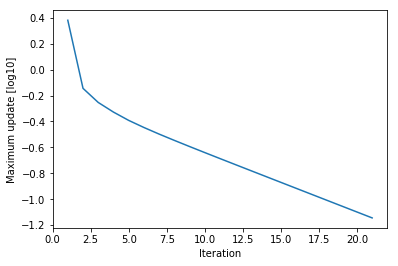

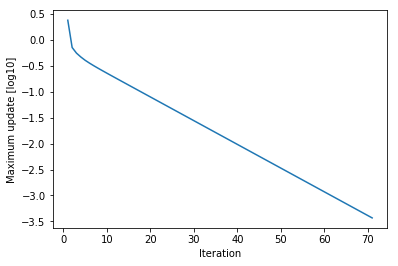

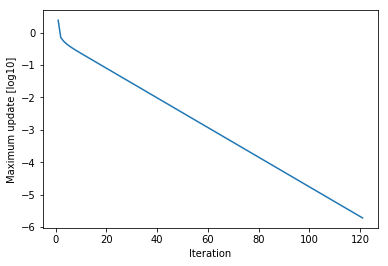

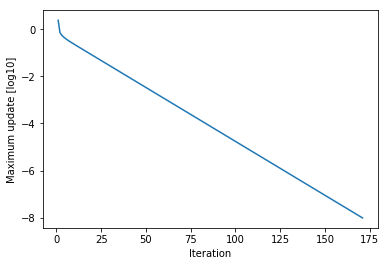

Converged after iteration 215


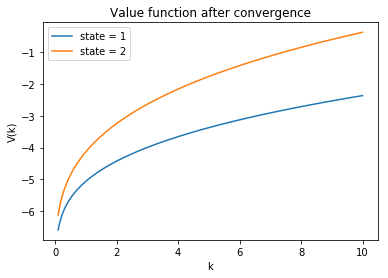

In [71]:
from matplotlib import pyplot as plt

difference_list = []
threshold = 1e-10
max_iterations = 10000
plot_interval = 50

V = V_init.copy()

for iteration in range(max_iterations):
    V_new = vf_update_iteration(V)
    difference = np.max(np.abs(V_new-V))
    difference_list.append(difference) # Nothing todo here
    V = V_new.copy()
    
    
    if difference < threshold:
        print('Converged after iteration {}'.format(iteration + 1))
        
        plt.figure()
        plt.plot(k_grid[0,:], V[0,:], label='state = 1')
        plt.plot(k_grid[0,:], V[1,:], label = 'state = 2')
        plt.legend()
        plt.xlabel('k')
        plt.ylabel('V(k)')
        plt.title('Value function after convergence')
        plt.show();
        break
        
    if iteration%plot_interval == 20:
        
        plt.figure()
        plt.plot(np.arange(1, iteration+2), np.log10(np.array(difference_list)))
        plt.xlabel('Iteration')
        plt.ylabel('Maximum update [log10]')
        plt.show();

## 4.5 Extracting the policy function
Since we have our value function, we can extract the policy function using
\begin{align}
p(k) = \text{arg}\max_{k'} u(k^{0.3} + 0.5 k - k') + \beta V(k').
\end{align}

In [74]:
def extract_policy(V):
    """
    input:
    V: value function array
    
    output:
    p: polcy function array
    """
    p = np.zeros_like(V)
    print(p.shape)
    for i in range(p.shape[1]):
        action_value = actionvalue_allchoices(i, V)
        p[:,i] = k_grid[0,action_value.argmax(axis=1)]
    
    return p

(2, 500)


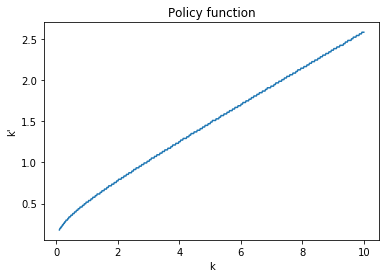

In [77]:
plt.figure()
policy = extract_policy(V)
plt.plot(k_grid[0,:], policy[0,:])
plt.xlabel('k')
plt.ylabel("k'")
plt.title('Policy function')
plt.show();